In [7]:
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt


pd.options.mode.chained_assignment = None  # default='warn'

folder = "./data/20210921/"
dfp_mapping = pd.read_csv("./data/train_breath_mapping.csv")

def plot_breath(dfp_train_breath_id, columns=["R","C", "u_in","u_out"], output_to_predict="pressure"):
    for column in columns:
        fig,ax=plt.subplots(figsize=(12,6))
        dfp_train_breath_id.plot(ax=ax, x="time_step", y=output_to_predict, color="r")
        dfp_train_breath_id.plot(ax=ax, x="time_step", y=column, color="b", secondary_y=True)
        fig.tight_layout()
        plt.show()

In [8]:
dfp_train_full = pd.read_csv(folder + "train.csv")

dfp_train = pd.merge(dfp_train_full, dfp_mapping[dfp_mapping["type_record"] == "training"]["breath_id"], on=["breath_id"])
dfp_train.sort_values(["breath_id", "time_step"], inplace=True)
dfp_validation_1 = pd.merge(dfp_train_full, dfp_mapping[dfp_mapping["type_record"] == "validation_I"]["breath_id"], on=["breath_id"])
dfp_validation_1.sort_values(["breath_id", "time_step"], inplace=True)
dfp_validation_2 = pd.merge(dfp_train_full, dfp_mapping[dfp_mapping["type_record"] == "validation_II"]["breath_id"], on=["breath_id"])
dfp_validation_2.sort_values(["breath_id", "time_step"], inplace=True)

# print(len(dfp_train), len(dfp_validation_1), len(dfp_validation_2))
del dfp_train_full

In [9]:
dfp_test = pd.read_csv(folder + "test.csv")
dfp_test.sort_values(["breath_id", "time_step"], inplace=True)

## Build original kaggle features

In [5]:
def add_features(df):
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_out__max'] = df.groupby(['breath_id'])['u_out'].transform('max')
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    df['cross']= df['u_in']*df['u_out']
    df['cross2']= df['time_step']*df['u_out']
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    return df

In [52]:
%%time
dfp_train_augmented = add_features(dfp_train)
dfp_train_augmented.to_csv(f"./data/final_datasets/train_final.csv", index=None)

dfp_validation_1_augmented = add_features(dfp_validation_1)
dfp_validation_1_augmented.to_csv(f"./data/final_datasets/validation1_final.csv", index=None)
dfp_validation_2_augmented = add_features(dfp_validation_2)
dfp_validation_2_augmented.to_csv(f"./data/final_datasets/validation2_final.csv", index=None)

CPU times: user 3min 12s, sys: 5.09 s, total: 3min 17s
Wall time: 3min 18s


In [6]:
dfp_test_augmented = add_features(dfp_test)
dfp_test_augmented.to_csv(f"./data/final_datasets/test_final.csv", index=None)

## Build original kaggle features + extra

In [14]:
breath_ids = dfp_mapping[dfp_mapping["type_record"] == "validation_II"]["breath_id"].unique()

In [12]:
def build_regime(time_step, time_step_threshold, time_step_max):
    regime = -1
    if time_step <= time_step_threshold and time_step_threshold != 0:
        regime = -1 * (1 - (time_step / time_step_threshold))
    else:
        regime = 1 - (time_step_max - time_step) / (time_step_max - time_step_threshold)
    return regime

def add_features(df):
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_out__max'] = df.groupby(['breath_id'])['u_out'].transform('max')
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    df['cross']= df['u_in']*df['u_out']
    df['cross2']= df['time_step']*df['u_out']
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    
    df["time_step_max"] = df.groupby(['breath_id'])['time_step'].transform('max')
    df_u_out_features = df[df["u_out"] == 1].groupby("breath_id").agg({"time_step" : "min"}).reset_index()
    df_u_out_features.columns = ["breath_id", "time_u_out_switch_regime"]
    df = pd.merge(df, df_u_out_features, on=["breath_id"])
    
    df["u_out_regime"] = df.apply(lambda row: build_regime(row["time_step"], row["time_u_out_switch_regime"], row["time_step_max"]), axis=1)
    
    df_u_in_features = df.loc[df.groupby(["breath_id"])["u_in"].idxmax()][["breath_id", "time_step"]]
    df_u_in_features.columns = ["breath_id", "time_u_in_switch_regime"]
    df = pd.merge(df, df_u_in_features, on=["breath_id"])
    df["u_in_regime"] = df.apply(lambda row: build_regime(row["time_step"], row["time_u_in_switch_regime"], row["time_step_max"]), axis=1)
    
    
    df.drop(['time_u_out_switch_regime', 'time_u_in_switch_regime', 'time_step_max'], axis=1, inplace=True)
    
    return df

In [23]:
%%time
dfp_train_augmented = add_features(dfp_train)
dfp_train_augmented.to_csv(f"./data/final_datasets/train_final_2.csv", index=None)

dfp_validation_1_augmented = add_features(dfp_validation_1)
dfp_validation_1_augmented.to_csv(f"./data/final_datasets/validation1_final_2.csv", index=None)
dfp_validation_2_augmented = add_features(dfp_validation_2)
dfp_validation_2_augmented.to_csv(f"./data/final_datasets/validation2_final_2.csv", index=None)

CPU times: user 5min 20s, sys: 14 s, total: 5min 34s
Wall time: 5min 35s


In [24]:
dfp_test_augmented = add_features(dfp_test)
dfp_test_augmented.to_csv(f"./data/final_datasets/test_final_2.csv", index=None)

In [32]:
dfp_breah = dfp_validation_2_augmented[dfp_validation_2_augmented["breath_id"] == breath_ids[15]].sort_values(["time_step"])

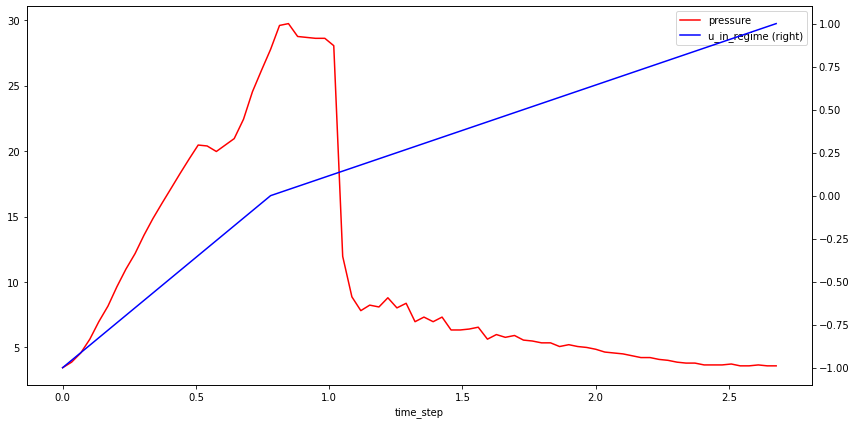

In [33]:
plot_breath(dfp_breah, ["u_in_regime"], "pressure")